In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import cufflinks as cf
import missingno as msno
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import davies_bouldin_score, silhouette_score

%matplotlib inline
cf.go_offline()
pd.set_option('display.max_rows', 60)
# pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: "{:,.4f}".format(x))
pd.set_option('display.max_columns', 100)

# Obtener datos

In [2]:
client = pd.read_csv("datos/client.asc", sep=";")

In [3]:
account = pd.read_csv("datos/account.asc", sep=";")

In [4]:
district = pd.read_csv("datos/district.asc", sep=";")

In [5]:
card = pd.read_csv("datos/card.asc", sep=";")

In [6]:
disp = pd.read_csv("datos/disp.asc", sep=";")

In [7]:
loan = pd.read_csv("datos/loan.asc", sep=";")

In [8]:
order = pd.read_csv("datos/order.asc", sep=";")

In [9]:
trans = pd.read_csv("datos/trans.asc", sep=";",low_memory=False)

In [ ]:
client - información
account - información cuenta
district - información distrito
card - tarjetas
disp - derechos de los clientes para usar cuenta - propietario/usuario
loan - prestamos
order - ordenes permanetes pagos fijos
trans - transacciones

# Funciones

In [10]:
def genero(x):
    n = int(x[2:4])
    if(n>12):
        return 'M'
    else:
        return 'H'

In [11]:
def date_genre(x):
    x = list(x)
    n = int(''.join(x[2:4]))
    if(n>12):
        n = n-50
        if(n<=9):
            x[2]='0'
            x[3]=str(n)
        else:
            n = str(n)
            x[2:4] = n[:]
        return ''.join(x)
    else:
        return ''.join(x)

In [ ]:
x = "706213"

In [ ]:
x[2:4]

In [ ]:
date_genre(x)

In [ ]:
genero(x)

# Información de las tablas

## Client

In [12]:
client.head(2)

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1


In [13]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


In [14]:
client['birth_number'] = client['birth_number'].astype(str)

In [15]:
client['genre'] = client['birth_number'].map(genero)

In [16]:
client['birth'] = client['birth_number'].map(date_genre)

In [17]:
client['birth'] = '19'+client['birth']

In [18]:
client['birth']=pd.to_datetime(client['birth'], format="%Y%m%d")

In [19]:
client['diff'] = '19990101'
client['diff']=pd.to_datetime(client['diff'], format="%Y%m%d")

In [20]:
client['age'] = (client['diff'] - client['birth']).dt.days/365.2425

In [21]:
client['age'] = client['age'].astype(int)

In [22]:
client.head(3)

,client_id,birth_number,district_id,genre,birth,diff,age
0,1,706213,18,M,1970-12-13,1999-01-01,28
1,2,450204,1,H,1945-02-04,1999-01-01,53
2,3,406009,1,M,1940-10-09,1999-01-01,58


## District 

In [23]:
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


In [24]:
district.head(5)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0000,12541,0.29,0.4300,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7000,8507,1.67,1.8500,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7000,8980,1.95,2.2100,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4000,9753,4.64,5.0500,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4000,9307,3.85,4.4300,118,2616,3040


In [25]:
district.columns = ["district_id","nombre_distrito","region","no_habitantes","no_municipios_con_habitantes<499",
                    "no_municipios_con_habitantes500-1999","no_municipios_con_habitantes_2000-9999",
                    "no_municipios_con_habitantes>10000","no_ciudades","ratio_habitantes_urbanos","salario_promedio",
                    "tasa_desempleo_1995","tasa_desempleo_1996","no_emprendedores_por_1000_habitantes",
                    "numero_delitos_cometidos_1995","numero_delitos_cometidos_1996"]

## Card

In [26]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [27]:
card.head(2)

,card_id,disp_id,type,issued
0,1005,9285,classic,931107 00:00:00
1,104,588,classic,940119 00:00:00


In [28]:
card['date'] = card['issued'].str.extract(r'([0-9]{6})')

In [29]:
card['date'] = '19'+card['date']
card['date'] = pd.to_datetime(card['date'], format="%Y%m%d")

In [30]:
card.rename(columns={'type':'type_card'}, inplace=True)

## Disposition

In [31]:
disp.head(3)

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT


In [32]:
disp_ = disp.groupby(['account_id'])['disp_id'].count().reset_index()#.sort_values(by='disp_id')

In [33]:
disp_.columns = ['account_id','disp_count']

In [34]:
disp_

,account_id,disp_count
0,1,1
1,2,2
2,3,2
3,4,1
4,5,1
...,...,...
4495,11333,1
4496,11349,2
4497,11359,1
4498,11362,1


## Loan

In [35]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    int64  
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 37.4+ KB


In [36]:
loan.head(2)

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,"8,033.0000",B
1,5316,1801,930711,165960,36,"4,610.0000",A


In [37]:
loan.status = loan.status.replace({"A": 'c_terminado_sin_problema', "B": 'c_terminado_prestamo_no_pagado', "C": 'c_en_ejecucion_hasta_ahora', "D": 'c_en_ejecucion_client_endeudado'})
loan['date'] = loan['date'].astype(str)
loan['date'] = '19'+loan['date']
loan['date']=pd.to_datetime(loan['date'], format="%Y%m%d")

## order

In [38]:
order.head(3)

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29401,1,YZ,87144583,"2,452.0000",SIPO
1,29402,2,ST,89597016,"3,372.7000",UVER
2,29403,2,QR,13943797,"7,266.0000",SIPO


In [39]:
order.k_symbol = order.k_symbol.replace({"POJISTNE": 'pago_seguro', "SIPO": 'pago_domestico',
                                         "LEASING": 'pago_arrendamiento', "UVER": 'pago_prestamo'," ": 'otros'})

In [40]:
order['value'] = 1

In [41]:
aux = order[['account_id','amount']].groupby(['account_id']).sum().reset_index()

In [42]:
order_k = pd.crosstab(order['account_id'],order['k_symbol']).reset_index()#.reset_index(drop=True)

In [43]:
for i in [x for x in order_k.columns if x!='account_id']:
    order_k[i] = order_k[i].replace(2,1)

In [44]:
order_k = order_k.merge(aux, on='account_id')

In [45]:
order_k

,account_id,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,amount
0,1,0,0,1,0,0,"2,452.0000"
1,2,0,0,1,1,0,"10,638.7000"
2,3,1,0,1,0,1,"5,001.0000"
3,4,0,0,1,0,0,"3,363.0000"
4,5,0,0,1,0,0,"2,668.0000"
...,...,...,...,...,...,...,...
3753,11328,0,0,0,1,0,"4,674.0000"
3754,11333,0,1,0,0,0,"3,286.7000"
3755,11349,0,0,1,1,0,"17,884.0000"
3756,11359,1,0,1,1,0,"9,274.3000"


## Transactions

In [46]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB


In [47]:
trans['account'] = trans['account'].astype(str)

In [48]:
trans.head(5)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0000,700.0000,NaN,NaN,nan
1,171812,576,930101,PRIJEM,VKLAD,900.0000,900.0000,NaN,NaN,nan
2,207264,704,930101,PRIJEM,VKLAD,"1,000.0000","1,000.0000",NaN,NaN,nan
3,1117247,3818,930101,PRIJEM,VKLAD,600.0000,600.0000,NaN,NaN,nan
4,579373,1972,930102,PRIJEM,VKLAD,400.0000,400.0000,NaN,NaN,nan


In [49]:
trans.type = trans.type.replace({"PRIJEM": 'credito', "VYDAJ": 'debito', "VYBER":'retiro_en_efectivo'})

In [50]:
trans.operation = trans.operation.replace({"VYBER KARTOU": 'retiro_tarjeta_cred', "VKLAD": 'credito_en_efectivo',
                                           "PREVOD Z UCTU":'cobro_otro_banco',"VYBER":'retiro_en_efectivo',
                                           "PREVOD NA UCET":'remesa_otro_banco',
                                           np.nan: "no_aplica"})

In [51]:
trans.k_symbol.unique()

array([nan, 'DUCHOD', 'UROK', 'SIPO', 'SLUZBY', ' ', 'POJISTNE',
       'SANKC. UROK', 'UVER'], dtype=object)

In [52]:
trans.k_symbol = trans.k_symbol.replace({"POJISTNE": 'pago_seguro', "SLUZBY": 'pago_de_declaracion',
                                         "UROK":'interes_acreditado',
                                         "SANKC. UROK": 'interes_de_sancion_si_saldo_negativo',
                                         "SIPO": 'pago_domestico',"DUCHOD": 'pago_de_pension',
                                         "UVER": 'pago_de_prestamo',
                                         np.nan: "no_aplica",
                                         " ": "no_aplica"})

In [53]:
trans['bank'] = trans['bank'].replace(np.nan, "no_aplica") 
trans['account'] = trans['account'].replace(np.nan, "no_aplica")

In [54]:
trans['date'] = trans['date'].astype(str)
trans['date'] = "19"+trans['date']
trans['date']=pd.to_datetime(trans['date'], format= '%Y%m%d')

In [55]:
trans.operation.unique()

array(['credito_en_efectivo', 'cobro_otro_banco', 'retiro_en_efectivo',
       'no_aplica', 'remesa_otro_banco', 'retiro_tarjeta_cred'],
      dtype=object)

## Account

In [56]:
account.head(2)

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,930101
1,3818,74,POPLATEK MESICNE,930101


In [57]:
account.frequency = account.frequency.replace({"POPLATEK MESICNE": 'emision_mensual',
                                               "POPLATEK TYDNE": 'emision_semanal',
                                               "POPLATEK PO OBRATU": 'emision_desp_tans'})

In [58]:
account['date'] = account['date'].astype(str)
account['date'] = '19'+account['date']
account['date']=pd.to_datetime(account['date'], format="%Y%m%d")

# Tarjetas de Crédito y Préstamos

In [59]:
trans['quarter'] = trans.date.dt.quarter
trans['year'] = trans.date.dt.year
trans['month'] = trans.date.dt.month

In [60]:
trans.head(5)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,quarter,year,month
0,695247,2378,1993-01-01,credito,credito_en_efectivo,700.0000,700.0000,no_aplica,no_aplica,nan,1,1993,1
1,171812,576,1993-01-01,credito,credito_en_efectivo,900.0000,900.0000,no_aplica,no_aplica,nan,1,1993,1
2,207264,704,1993-01-01,credito,credito_en_efectivo,"1,000.0000","1,000.0000",no_aplica,no_aplica,nan,1,1993,1
3,1117247,3818,1993-01-01,credito,credito_en_efectivo,600.0000,600.0000,no_aplica,no_aplica,nan,1,1993,1
4,579373,1972,1993-01-02,credito,credito_en_efectivo,400.0000,400.0000,no_aplica,no_aplica,nan,1,1993,1


In [61]:
a = trans[['account_id',
           'type','date',
           'amount',
           'balance']].groupby(['account_id',
                                'type',pd.Grouper(key='date', freq='M')]).agg(['count',max,min,'mean'])

In [62]:
a.reset_index(inplace=True)
a.columns=[x+'_'+y for x,y in a.columns]

In [63]:
cols = [x for x in a.columns if x not in ['index_','date_','account_id_','type_']]

In [64]:
aux_trans = a.groupby(['account_id_','type_'])[cols].agg('mean').reset_index()

In [65]:
trans_credito = aux_trans.loc[aux_trans.type_=='credito'].copy()
trans_debito = aux_trans.loc[aux_trans.type_=='debito'].copy()
trans_efectivo = aux_trans.loc[aux_trans.type_=='retiro_en_efectivo'].copy()

In [66]:
trans_credito.columns = ["c_"+x if x not in ['account_id_','type_'] else x[:-1] for x in trans_credito.columns]
trans_debito.columns = ["d_"+x if x not in ['account_id_','type_'] else x[:-1] for x in trans_debito.columns]
trans_efectivo.columns = ["f_"+x if x not in ['account_id_','type_'] else x[:-1] for x in trans_efectivo.columns]

In [67]:
trans_credito

,account_id,type,c_amount_count,c_amount_max,c_amount_min,c_amount_mean,c_balance_count,c_balance_max,c_balance_min,c_balance_mean
0,1,credito,2.2174,"3,814.6957",88.3804,"1,884.4957",2.2174,"17,732.1609","15,862.4652","16,878.0645"
2,2,credito,2.1408,"21,676.5634",166.4437,"10,593.9110",2.1408,"47,497.1972","34,441.5944","41,089.7023"
5,3,credito,2.5556,"8,143.7222",115.0000,"3,873.6787",2.5556,"29,844.7889","27,182.9944","28,733.5259"
7,4,credito,1.8571,"5,417.2000",735.8857,"3,076.5429",1.8571,"23,078.0229","20,680.7114","21,879.3671"
9,5,credito,1.7500,"4,796.1500","1,111.5000","2,953.8250",1.7500,"23,692.5850","22,414.8650","23,053.7250"
...,...,...,...,...,...,...,...,...,...,...
10130,11333,credito,3.2679,"20,276.3018",383.6161,"7,956.4446",3.2679,"58,605.5107","38,353.6839","47,773.7226"
10133,11349,credito,2.0682,"44,855.3636",173.6182,"21,907.3076",2.0682,"78,676.6955","36,625.5091","56,873.4727"
10136,11359,credito,2.0392,"29,397.5882",164.0039,"14,629.7444",2.0392,"54,830.8216","37,848.6804","46,515.6797"
10139,11362,credito,2.0769,"17,201.4103",133.7359,"8,468.7115",2.0769,"38,688.2744","23,065.0897","30,793.7329"


In [68]:
loan.groupby(['status']).count()

,loan_id,account_id,date,amount,duration,payments
status,,,,,,
c_en_ejecucion_client_endeudado,45,45,45,45,45,45
c_en_ejecucion_hasta_ahora,403,403,403,403,403,403
c_terminado_prestamo_no_pagado,31,31,31,31,31,31
c_terminado_sin_problema,203,203,203,203,203,203


# Merge

In [69]:
client[['client_id','district_id','genre','age']].head(2)

,client_id,district_id,genre,age
0,1,18,M,28
1,2,1,H,53


In [70]:
aux = client[['client_id','district_id','genre','age']].copy()

In [71]:
dist_cols = ['district_id', 'no_habitantes','no_ciudades',
       'ratio_habitantes_urbanos', 'salario_promedio', 'tasa_desempleo_1995',
       'tasa_desempleo_1996', 'no_emprendedores_por_1000_habitantes',
       'numero_delitos_cometidos_1995', 'numero_delitos_cometidos_1996']

In [72]:
aux = disp.loc[disp.type=='OWNER',['client_id','account_id','disp_id']].merge(aux, on='client_id', how='left').merge(district[dist_cols], on='district_id', how="left")

In [73]:
card.head(2)

,card_id,disp_id,type_card,issued,date
0,1005,9285,classic,931107 00:00:00,1993-11-07
1,104,588,classic,940119 00:00:00,1994-01-19


In [74]:
disp.loc[disp.type == "OWNER"].head(2)

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER


In [75]:
aux.head(2)

,client_id,account_id,disp_id,district_id,genre,age,no_habitantes,no_ciudades,ratio_habitantes_urbanos,salario_promedio,tasa_desempleo_1995,tasa_desempleo_1996,no_emprendedores_por_1000_habitantes,numero_delitos_cometidos_1995,numero_delitos_cometidos_1996
0,1,1,1,18,M,28,70699,4,65.3000,8968,2.83,3.3500,131,1740,1910
1,2,2,2,1,H,53,1204953,1,100.0000,12541,0.29,0.4300,167,85677,99107


In [76]:
disp_.head(2)

,account_id,disp_count
0,1,1
1,2,2


In [77]:
order_k.rename(columns={'amount':'total_amount_orders'},inplace=True)

In [78]:
order_k.head(2)

,account_id,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,total_amount_orders
0,1,0,0,1,0,0,"2,452.0000"
1,2,0,0,1,1,0,"10,638.7000"


In [79]:
account.head(2)

,account_id,district_id,frequency,date
0,576,55,emision_mensual,1993-01-01
1,3818,74,emision_mensual,1993-01-01


In [80]:
aux = aux.merge(disp_, on='account_id', how='left').merge(order_k, on='account_id', how='left').merge(account[['account_id','frequency']], on='account_id',how='left')

In [81]:
aux.head(2)

,client_id,account_id,disp_id,district_id,genre,age,no_habitantes,no_ciudades,ratio_habitantes_urbanos,salario_promedio,tasa_desempleo_1995,tasa_desempleo_1996,no_emprendedores_por_1000_habitantes,numero_delitos_cometidos_1995,numero_delitos_cometidos_1996,disp_count,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,total_amount_orders,frequency
0,1,1,1,18,M,28,70699,4,65.3000,8968,2.83,3.3500,131,1740,1910,1,0.0000,0.0000,1.0000,0.0000,0.0000,"2,452.0000",emision_mensual
1,2,2,2,1,H,53,1204953,1,100.0000,12541,0.29,0.4300,167,85677,99107,2,0.0000,0.0000,1.0000,1.0000,0.0000,"10,638.7000",emision_mensual


In [82]:
trans_debito.rename(columns={'type':'type_debito'},inplace=True)
trans_credito.rename(columns={'type':'type_credito'},inplace=True)
trans_efectivo.rename(columns={'type':'type_efectivo'},inplace=True)

In [83]:
trans_debito.rename(columns={'d_amount_count':'d_trans_count'},inplace=True)
trans_debito.drop(['d_balance_count'], axis=1,inplace=True)
trans_credito.rename(columns={'c_amount_count':'c_trans_count'},inplace=True)
trans_credito.drop(['c_balance_count'], axis=1,inplace=True)
trans_efectivo.rename(columns={'f_amount_count':'f_trans_count'},inplace=True)
trans_efectivo.drop(['f_balance_count'], axis=1,inplace=True)

In [84]:
aux = aux.merge(trans_credito, on='account_id', how='left').merge(trans_debito, on='account_id', how='left').merge(trans_efectivo, on='account_id', how='left')

In [85]:
aux.columns

Index(['client_id', 'account_id', 'disp_id', 'district_id', 'genre', 'age',
       'no_habitantes', 'no_ciudades', 'ratio_habitantes_urbanos',
       'salario_promedio', 'tasa_desempleo_1995', 'tasa_desempleo_1996',
       'no_emprendedores_por_1000_habitantes', 'numero_delitos_cometidos_1995',
       'numero_delitos_cometidos_1996', 'disp_count', 'otros',
       'pago_arrendamiento', 'pago_domestico', 'pago_prestamo', 'pago_seguro',
       'total_amount_orders', 'frequency', 'type_credito', 'c_trans_count',
       'c_amount_max', 'c_amount_min', 'c_amount_mean', 'c_balance_max',
       'c_balance_min', 'c_balance_mean', 'type_debito', 'd_trans_count',
       'd_amount_max', 'd_amount_min', 'd_amount_mean', 'd_balance_max',
       'd_balance_min', 'd_balance_mean', 'type_efectivo', 'f_trans_count',
       'f_amount_max', 'f_amount_min', 'f_amount_mean', 'f_balance_max',
       'f_balance_min', 'f_balance_mean'],
      dtype='object')

In [86]:
aux.drop(['type_efectivo','type_debito','type_credito'], axis=1, inplace=True)

In [87]:
aux.loc[aux.tasa_desempleo_1995=='?','tasa_desempleo_1995'] = "7.0100"
aux.loc[aux.numero_delitos_cometidos_1995=='?','numero_delitos_cometidos_1995'] = "1358"
aux.numero_delitos_cometidos_1995 = aux.numero_delitos_cometidos_1995.astype(float)
aux.tasa_desempleo_1995 = aux.tasa_desempleo_1995.astype(float)

In [88]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4499
Data columns (total 44 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   client_id                             4500 non-null   int64  
 1   account_id                            4500 non-null   int64  
 2   disp_id                               4500 non-null   int64  
 3   district_id                           4500 non-null   int64  
 4   genre                                 4500 non-null   object 
 5   age                                   4500 non-null   int32  
 6   no_habitantes                         4500 non-null   int64  
 7   no_ciudades                           4500 non-null   int64  
 8   ratio_habitantes_urbanos              4500 non-null   float64
 9   salario_promedio                      4500 non-null   int64  
 10  tasa_desempleo_1995                   4500 non-null   float64
 11  tasa_desempleo_19

In [89]:
aux.genre = aux.genre.astype("category").cat.codes
aux.frequency = aux.frequency.astype("category").cat.codes

In [90]:
for i in aux.columns:
    aux[i].fillna(0,inplace=True)

In [91]:
aux.head()

,client_id,account_id,disp_id,district_id,genre,age,no_habitantes,no_ciudades,ratio_habitantes_urbanos,salario_promedio,tasa_desempleo_1995,tasa_desempleo_1996,no_emprendedores_por_1000_habitantes,numero_delitos_cometidos_1995,numero_delitos_cometidos_1996,disp_count,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,total_amount_orders,frequency,c_trans_count,c_amount_max,c_amount_min,c_amount_mean,c_balance_max,c_balance_min,c_balance_mean,d_trans_count,d_amount_max,d_amount_min,d_amount_mean,d_balance_max,d_balance_min,d_balance_mean,f_trans_count,f_amount_max,f_amount_min,f_amount_mean,f_balance_max,f_balance_min,f_balance_mean
0,1,1,1,18,1,28,70699,4,65.3000,8968,2.8300,3.3500,131,"1,740.0000",1910,1,0.0000,0.0000,1.0000,0.0000,0.0000,"2,452.0000",1,2.2174,"3,814.6957",88.3804,"1,884.4957","17,732.1609","15,862.4652","16,878.0645",3.1860,"2,897.9535",198.5116,"1,464.1950","17,005.4209","13,982.9372","15,641.1555",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2,2,2,1,0,53,1204953,1,100.0000,12541,0.2900,0.4300,167,"85,677.0000",99107,2,0.0000,0.0000,1.0000,1.0000,0.0000,"10,638.7000",1,2.1408,"21,676.5634",166.4437,"10,593.9110","47,497.1972","34,441.5944","41,089.7023",4.4203,"9,001.0435",778.9710,"4,724.0312","42,992.0638","25,734.3725","34,748.6680",1.1667,"11,205.1111","10,700.1667","10,966.8148","36,806.7611","35,619.1167","36,234.0185"
2,4,3,4,5,0,42,95616,6,51.4000,9307,3.8500,4.4300,118,"2,616.0000",3040,2,1.0000,0.0000,1.0000,0.0000,1.0000,"5,001.0000",1,2.5556,"8,143.7222",115.0000,"3,873.6787","29,844.7889","27,182.9944","28,733.5259",4.4375,"4,049.3750",613.5500,"2,028.5819","30,388.8125","22,870.3812","26,535.1855",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,6,4,6,12,0,79,107870,6,58.0000,8754,3.8300,4.3100,137,"3,804.0000",3868,1,0.0000,0.0000,1.0000,0.0000,0.0000,"3,363.0000",1,1.8571,"5,417.2000",735.8857,"3,076.5429","23,078.0229","20,680.7114","21,879.3671",4.0333,"2,419.2667",34.1133,"1,277.1351","23,569.1433","19,196.3600","21,648.8352",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,7,5,7,15,0,69,58796,5,51.9000,9045,3.1300,3.6000,124,"1,845.0000",1879,1,0.0000,0.0000,1.0000,0.0000,0.0000,"2,668.0000",1,1.7500,"4,796.1500","1,111.5000","2,953.8250","23,692.5850","22,414.8650","23,053.7250",3.2667,"2,748.7067",20.2933,"1,371.0861","26,802.0600","23,333.7600","25,333.8300",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [92]:
used_cols = [x for x in [x for x in aux.columns if x!='no_ciudades'] if x.endswith('_id')==False]

# First Model

### Scaler

In [93]:
ss_x = StandardScaler()
ss_x.fit(aux[used_cols])
scaler = pd.DataFrame(ss_x.transform(aux[used_cols]), columns=used_cols)

### T-SNE

In [94]:
tsne = TSNE(n_components=2, perplexity=60)
Xt = pd.DataFrame(tsne.fit_transform(scaler),columns=['d1','d2'])

In [95]:
Xt.iplot(x="d1", y="d2",kind="scatter", mode='markers', title=f"T-SNE 3 Componets Perplexity 30")

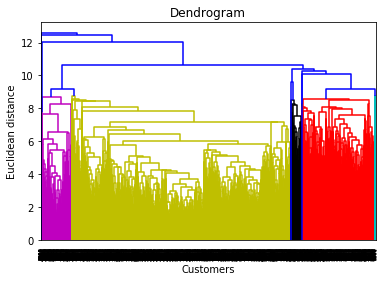

In [96]:
dendrogram = sch.dendrogram(sch.linkage(scaler, method = 'average'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

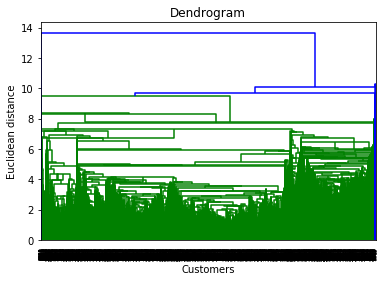

In [97]:
dendrogram = sch.dendrogram(sch.linkage(scaler, method = 'centroid'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

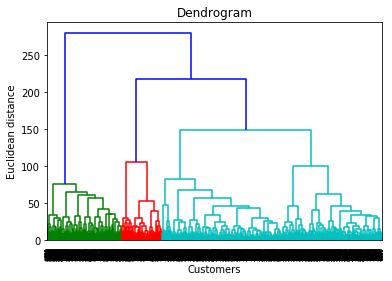

In [98]:
dendrogram = sch.dendrogram(sch.linkage(scaler, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

In [99]:
cluster = AgglomerativeClustering(linkage='ward', n_clusters=3)
aux["cluster"] = cluster.fit_predict(scaler)
Xt["cluster"] = cluster.fit_predict(scaler)

In [100]:
aux["cluster"].value_counts().iplot(kind="bar")

In [101]:
Xt['cluster'] = Xt['cluster'].astype(str)

In [102]:
Xt.iplot(x="d1", y="d2",kind="scatter", mode='markers', categories='cluster', title=f"T-SNE 3 Componets Perplexity 30")

c:\python37\lib\site-packages\cufflinks\plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

c:\python37\lib\site-packages\cufflinks\plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [103]:
aux[[x for x in aux.columns if x.endswith('_id')==False]].groupby("cluster").mean().style.background_gradient(cmap='Blues')

,genre,age,no_habitantes,no_ciudades,ratio_habitantes_urbanos,salario_promedio,tasa_desempleo_1995,tasa_desempleo_1996,no_emprendedores_por_1000_habitantes,numero_delitos_cometidos_1995,numero_delitos_cometidos_1996,disp_count,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,total_amount_orders,frequency,c_trans_count,c_amount_max,c_amount_min,c_amount_mean,c_balance_max,c_balance_min,c_balance_mean,d_trans_count,d_amount_max,d_amount_min,d_amount_mean,d_balance_max,d_balance_min,d_balance_mean,f_trans_count,f_amount_max,f_amount_min,f_amount_mean,f_balance_max,f_balance_min,f_balance_mean
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.496781,45.515080,137877.416808,6.166723,65.149238,9079.820400,3.273294,3.909254,114.595730,4686.180617,4725.961369,1.198238,0.270078,0.031176,0.824805,0.070485,0.114876,3934.793358,1.002033,2.093625,10881.543596,329.647245,5455.590074,36928.779713,29849.618915,33408.212700,3.552127,7039.207296,690.070591,3387.924158,34880.431884,27709.388998,31126.048720,0.000678,4.278550,4.278550,4.278550,17.239868,17.239868,17.239868
1,0.474576,40.232303,137746.584247,6.118644,64.419641,9121.757727,3.313480,3.963519,115.311067,4668.469591,4696.783649,1.167498,0.250249,0.196411,0.512463,0.426720,0.118644,6817.688335,1.114656,2.443728,25760.857130,279.355523,12628.752099,63321.070411,40997.829959,52069.539872,3.657920,18577.110445,1675.245398,8644.739122,55279.513287,34770.869151,44315.065339,1.250748,13325.253916,11566.450124,12444.154623,45887.599235,41777.304770,43824.129813
2,0.487179,43.701465,1204953.000000,1.000000,100.000000,12541.000000,0.290000,0.430000,167.000000,85677.000000,99107.000000,1.212454,0.274725,0.095238,0.763736,0.148352,0.135531,5090.250916,1.047619,2.187468,15236.852646,311.752833,7556.759194,44511.117013,32992.887877,38734.617606,3.609503,10349.602385,1033.043875,4884.148279,40996.895423,29843.584618,35071.442150,0.321656,3410.018518,2923.447280,3162.594905,12126.505833,11125.508153,11627.423819


In [104]:
aux[[x for x in aux.columns if x.endswith('_id')==False]].groupby("cluster").mean().to_csv("perfilamiento3clusters.csv", index=False)

# Segundo modelo

In [105]:
loan.head(2)

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,"8,033.0000",c_terminado_prestamo_no_pagado
1,5316,1801,1993-07-11,165960,36,"4,610.0000",c_terminado_sin_problema


In [106]:
loan.rename(columns = {'date':'date_loan','amount':'amount_loan'}, inplace=True)

In [107]:
t = ['trans_id', 'account_id', 'date', 'type', 'operation', 'amount','balance', 'k_symbol']

In [108]:
loan_aux = loan.merge(trans[t], on='account_id', how='left')

In [109]:
loan_aux['diff_days'] = (loan_aux['date_loan']-loan_aux['date']).dt.days

In [110]:
loan_aux.head(2)

,loan_id,account_id,date_loan,amount_loan,duration,payments,status,trans_id,date,type,operation,amount,balance,k_symbol,diff_days
0,5314,1787,1993-07-05,96396,12,"8,033.0000",c_terminado_prestamo_no_pagado,523621,1993-03-22,credito,credito_en_efectivo,"1,100.0000","1,100.0000",no_aplica,105
1,5314,1787,1993-07-05,96396,12,"8,033.0000",c_terminado_prestamo_no_pagado,524054,1993-04-21,credito,credito_en_efectivo,"9,900.0000","11,000.0000",no_aplica,75


In [231]:
#dic = {'loan_id':[],'amount_mean_3MA':[],'amount_mean_3MB':[],'balance_mean_3MA':[],'balance_mean_3MB':[],'balance_mean':[],'amount_mean':[],'balance_max':[],'amount_max':[],'balance_min':[],'amount_min':[]}
dic = {'loan_id':[],'pay_bal':[],'balance_mean':[],'amount_mean':[],'balance_max':[],'amount_max':[],'balance_min':[],'amount_min':[]}
for idx, data in loan_aux[t+['loan_id','diff_days','payments']].groupby(['loan_id']):
    dic['loan_id'].append(idx)
    
    #aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'amount'].mean()
    #dic['amount_mean_3MB'].append(aux)
    #aux = data.loc[(data.diff_days<0)&(data.diff_days>=-90),'amount'].mean()
    #dic['amount_mean_3MA'].append(aux)
    #aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].mean()
    #dic['balance_mean_3MB'].append(aux)
    #aux = data.loc[(data.diff_days<0)&(data.diff_days>=-90),'balance'].mean()
    #dic['balance_mean_3MA'].append(aux)
    aux = data.payments.unique()[0]/(data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].mean()/3)
    #print(data.payments.unique()[0],(data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].mean()/3)
    dic['pay_bal'].append(aux)
    # ---
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=180),'amount'].mean()
    dic['amount_mean'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=180),'amount'].max()
    dic['amount_max'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=180),'amount'].min()
    dic['amount_min'].append(aux)
    # ---
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=180),'balance'].mean()
    dic['balance_mean'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=180),'balance'].max()
    dic['balance_max'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=180),'balance'].min()
    dic['balance_min'].append(aux)

In [ ]:
#dic = {'loan_id':[],'amount_mean_3MA':[],'amount_mean_3MB':[],'balance_mean_3MA':[],'balance_mean_3MB':[],'balance_mean':[],'amount_mean':[],'balance_max':[],'amount_max':[],'balance_min':[],'amount_min':[]}
dic = {'loan_id':[],'pay_bal1':[],'pay_bal2':[],'pay_bal3':[],
       'balance_mean1':[],'amount_mean1':[],'balance_mean2':[],'amount_mean2':[],'balance_mean3':[],'amount_mean3':[],
       'balance_max1':[],'amount_max1':[],'balance_max2':[],'amount_max2':[],'balance_max3':[],'amount_max3':[],
       'balance_min1':[],'amount_min1':[],'balance_min2':[],'amount_min2':[],'balance_min3':[],'amount_min3':[]}
for idx, data in loan_aux[t+['loan_id','diff_days','payments']].groupby(['loan_id']):
    dic['loan_id'].append(idx)
    
    #aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'amount'].mean()
    #dic['amount_mean_3MB'].append(aux)
    #aux = data.loc[(data.diff_days<0)&(data.diff_days>=-90),'amount'].mean()
    #dic['amount_mean_3MA'].append(aux)
    #aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].mean()
    #dic['balance_mean_3MB'].append(aux)
    #aux = data.loc[(data.diff_days<0)&(data.diff_days>=-90),'balance'].mean()
    #dic['balance_mean_3MA'].append(aux)
    aux = data.payments.unique()[0]/(data.loc[(data.diff_days>0)&(data.diff_days<=30),'balance'].mean())
    dic['pay_bal1'].append(aux)
    aux = data.payments.unique()[0]/(data.loc[(data.diff_days>0)&(data.diff_days<=60),'balance'].mean()/2)
    dic['pay_bal2'].append(aux)
    aux = data.payments.unique()[0]/(data.loc[(data.diff_days>0)&(data.diff_days<=90),'balance'].mean()/3)
    dic['pay_bal3'].append(aux)
    # ---
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=30),'amount'].mean()
    dic['amount_mean1'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=30),'amount'].max()
    dic['amount_max1'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=30),'amount'].min()
    dic['amount_min1'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=60),'amount'].mean()
    dic['amount_mean2'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=60),'amount'].max()
    dic['amount_max2'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=60),'amount'].min()
    dic['amount_min2'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'amount'].mean()
    dic['amount_mean3'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'amount'].max()
    dic['amount_max3'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'amount'].min()
    dic['amount_min3'].append(aux)
    # ---
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=30),'balance'].mean()
    dic['balance_mean1'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=30),'balance'].max()
    dic['balance_max1'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=30),'balance'].min()
    dic['balance_min1'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=60),'balance'].mean()
    dic['balance_mean2'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=60),'balance'].max()
    dic['balance_max2'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=60),'balance'].min()
    dic['balance_min2'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].mean()
    dic['balance_mean3'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].max()
    dic['balance_max3'].append(aux)
    aux = data.loc[(data.diff_days>=0)&(data.diff_days<=90),'balance'].min()
    dic['balance_min3'].append(aux)

In [232]:
trans_loan = pd.DataFrame.from_dict(dic)

In [233]:
trans_loan.head(2)

,loan_id,pay_bal,balance_mean,amount_mean,balance_max,amount_max,balance_min,amount_min
0,4959,0.3392,"31,123.6857","6,893.0071","62,325.5000","30,354.0000","10,508.0000",14.6000
1,4961,0.5005,"18,059.3167","5,674.9143","41,024.4000","22,708.0000",715.0000,14.6000


In [234]:
loan_f = loan.merge(trans_loan, on='loan_id', how='left')

In [235]:
loan_f.head(20)

,loan_id,account_id,date_loan,amount_loan,duration,payments,status,pay_bal,balance_mean,amount_mean,balance_max,amount_max,balance_min,amount_min
0,5314,1787,1993-07-05,96396,12,"8,033.0000",c_terminado_prestamo_no_pagado,1.5093,"12,250.0000","5,025.0000","20,100.0000","9,900.0000","1,100.0000","1,100.0000"
1,5316,1801,1993-07-11,165960,36,"4,610.0000",c_terminado_sin_problema,0.2468,"52,083.8595","11,015.6351","120,512.8000","54,300.0000",700.0000,2.9000
2,6863,9188,1993-07-28,127080,60,"2,118.0000",c_terminado_sin_problema,0.1807,"30,060.9542","5,417.4583","49,590.4000","19,065.0000",800.0000,48.6000
3,5325,1843,1993-08-03,105804,36,"2,939.0000",c_terminado_sin_problema,0.1901,"42,976.5417","8,555.2917","65,898.5000","26,448.0000","18,632.0000",14.6000
4,7240,11013,1993-09-06,274740,60,"4,579.0000",c_terminado_sin_problema,0.2259,"59,364.6808","19,651.5808","122,893.1000","63,366.0000","35,844.0000",30.0000
5,6687,8261,1993-09-13,87840,24,"3,660.0000",c_terminado_sin_problema,0.1896,"46,318.5529","9,496.9294","65,847.8000","32,938.0000",500.0000,51.3000
6,7284,11265,1993-09-15,52788,12,"4,399.0000",c_terminado_sin_problema,0.6401,"23,153.0892","3,590.8297","41,469.1000","17,920.0000","14,716.8000",14.6000
7,6111,5428,1993-09-24,174744,24,"7,281.0000",c_terminado_prestamo_no_pagado,1.0186,"37,485.4563","11,557.9500","105,628.0000","52,600.0000","1,000.0000",14.6000
8,7235,10973,1993-10-13,154416,48,"3,217.0000",c_terminado_sin_problema,0.2193,"46,715.8000","9,740.1500","81,723.5000","39,098.0000","8,897.0000",13.6000
9,5997,4894,1993-11-04,117024,24,"4,876.0000",c_terminado_sin_problema,0.2704,"44,131.1692","14,122.5769","76,985.2000","29,255.0000",800.0000,45.1000


In [236]:
aux = client[['client_id','district_id','genre','age']].copy()
aux = disp.loc[disp.type=='OWNER',['client_id','account_id','disp_id']].merge(card[['disp_id','type_card']],on='disp_id',how='left').merge(aux, on='client_id', how='left').merge(district[dist_cols], on='district_id', how="left")
aux = aux.merge(disp_, on='account_id', how='left').merge(order_k, on='account_id', how='left').merge(account[['account_id','frequency']], on='account_id',how='left')

In [237]:
aux.type_card.fillna('NA',inplace=True)

In [238]:
aux.head(2)

,client_id,account_id,disp_id,type_card,district_id,genre,age,no_habitantes,no_ciudades,ratio_habitantes_urbanos,salario_promedio,tasa_desempleo_1995,tasa_desempleo_1996,no_emprendedores_por_1000_habitantes,numero_delitos_cometidos_1995,numero_delitos_cometidos_1996,disp_count,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,total_amount_orders,frequency
0,1,1,1,NA,18,M,28,70699,4,65.3000,8968,2.83,3.3500,131,1740,1910,1,0.0000,0.0000,1.0000,0.0000,0.0000,"2,452.0000",emision_mensual
1,2,2,2,NA,1,H,53,1204953,1,100.0000,12541,0.29,0.4300,167,85677,99107,2,0.0000,0.0000,1.0000,1.0000,0.0000,"10,638.7000",emision_mensual


In [239]:
aux.loc[aux.tasa_desempleo_1995=='?','tasa_desempleo_1995'] = "7.0100"
aux.loc[aux.numero_delitos_cometidos_1995=='?','numero_delitos_cometidos_1995'] = "1358"
aux.numero_delitos_cometidos_1995 = aux.numero_delitos_cometidos_1995.astype(float)
aux.tasa_desempleo_1995 = aux.tasa_desempleo_1995.astype(float)

In [240]:
aux.fillna(0,inplace=True)

In [241]:
aux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4499
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   client_id                             4500 non-null   int64  
 1   account_id                            4500 non-null   int64  
 2   disp_id                               4500 non-null   int64  
 3   type_card                             4500 non-null   object 
 4   district_id                           4500 non-null   int64  
 5   genre                                 4500 non-null   object 
 6   age                                   4500 non-null   int32  
 7   no_habitantes                         4500 non-null   int64  
 8   no_ciudades                           4500 non-null   int64  
 9   ratio_habitantes_urbanos              4500 non-null   float64
 10  salario_promedio                      4500 non-null   int64  
 11  tasa_desempleo_19

In [242]:
df = loan_f.merge(aux, on='account_id',how='left')

In [243]:
df.genre = df.genre.astype("category").cat.codes
df.frequency = df.frequency.astype("category").cat.codes
df.type_card = df.type_card.astype("category").cat.codes

In [244]:
cols = [x for x in [x for x in df.columns if (x!='date_loan' and x!='status')] if x.endswith('_id')==False]

In [245]:
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   amount_loan                           682 non-null    int64  
 1   duration                              682 non-null    int64  
 2   payments                              682 non-null    float64
 3   pay_bal                               682 non-null    float64
 4   balance_mean                          682 non-null    float64
 5   amount_mean                           682 non-null    float64
 6   balance_max                           682 non-null    float64
 7   amount_max                            682 non-null    float64
 8   balance_min                           682 non-null    float64
 9   amount_min                            682 non-null    float64
 10  type_card                             682 non-null    int8   
 11  genre              

## scaler

In [246]:
X = df.loc[df.status.isin(['c_terminado_sin_problema','c_terminado_prestamo_no_pagado'])].copy()

In [247]:
ss_x = StandardScaler()
ss_x.fit(X[cols])
scaler = pd.DataFrame(ss_x.transform(X[cols]), columns=cols)

array([0.21827741, 0.36051874, 0.45041418, 0.54009019, 0.60502637,
       0.6561107 , 0.69821969, 0.73821546, 0.77562835, 0.81017024,
       0.84139933, 0.86998032, 0.89510646, 0.91936743])

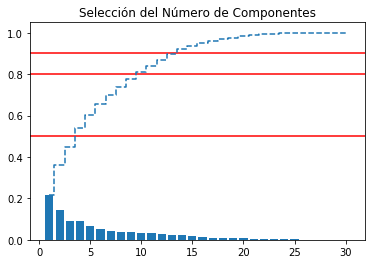

In [248]:
pca = PCA()
pca.fit(scaler)
display(pca.explained_variance_ratio_[:14].cumsum())
pca_ = pca.transform(scaler)
pca_ = pd.DataFrame(pca_, columns=['pc'+str(x) for x in range(1,len(cols)+1)])
plt.title("Selección del Número de Componentes")
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.axhline(y=.5, color='red')
plt.axhline(y=.8, color='red')
plt.axhline(y=.9, color='red')
plt.step(range(1,len(cols)+1), pca.explained_variance_ratio_.cumsum(), where='mid', linestyle='--', label='Varianza explicada acumulada')
plt.savefig("PCA.png", format="png", bbox_inches='tight')

In [249]:
pca_.iplot(x="pc1", y="pc2",kind="scatter", mode='markers', title=f"PCA 2 Componets")

In [250]:
mds = MDS(n_components=2,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(scaler),columns=['d1','d2'])
Xm.iplot(x="d1", y="d2",kind="scatter", mode='markers', title=f"MDS 2 Componets")

In [251]:
tsne = TSNE(n_components=2, perplexity=10)
Xt = pd.DataFrame(tsne.fit_transform(scaler),columns=['d1','d2'])

In [252]:
Xt.iplot(x="d1", y="d2",kind="scatter", mode='markers', title=f"T-SNE 3 Componets Perplexity 60")

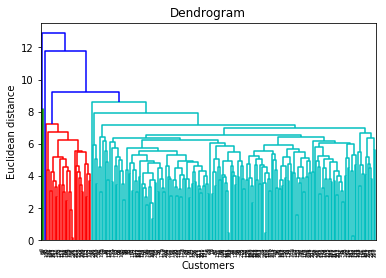

In [253]:
dendrogram = sch.dendrogram(sch.linkage(pca_, method = 'average'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

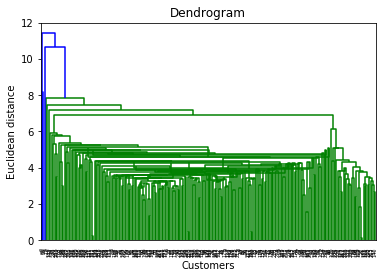

In [254]:
dendrogram = sch.dendrogram(sch.linkage(pca_, method = 'centroid'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

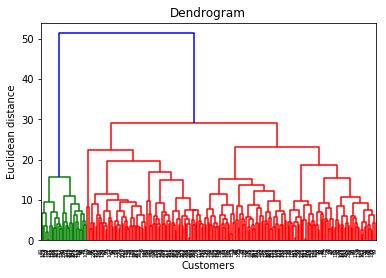

In [255]:
dendrogram = sch.dendrogram(sch.linkage(pca_, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distance')
plt.show()

In [256]:
sse,db,slc = {}, {}, {}
for k in range(2, 15):
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=10, n_jobs=-1).fit(pca_)
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    db[k] = davies_bouldin_score(pca_,clusters)
    slc[k] = silhouette_score(pca_,clusters)

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

c:\python37\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning:

'n_jobs' was deprecated in version

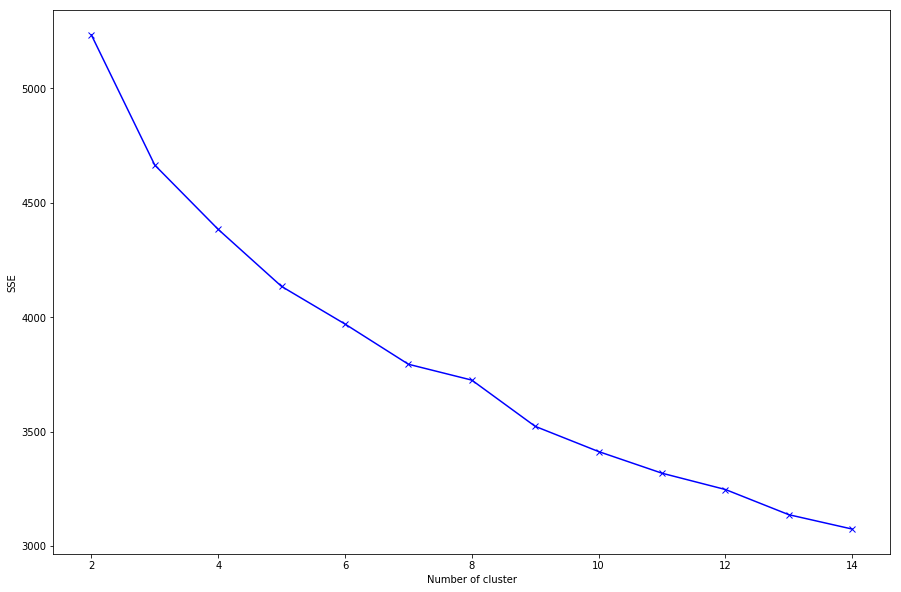

In [257]:
plt.figure(figsize=(15,10))
plt.plot(list(sse.keys()), list(sse.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

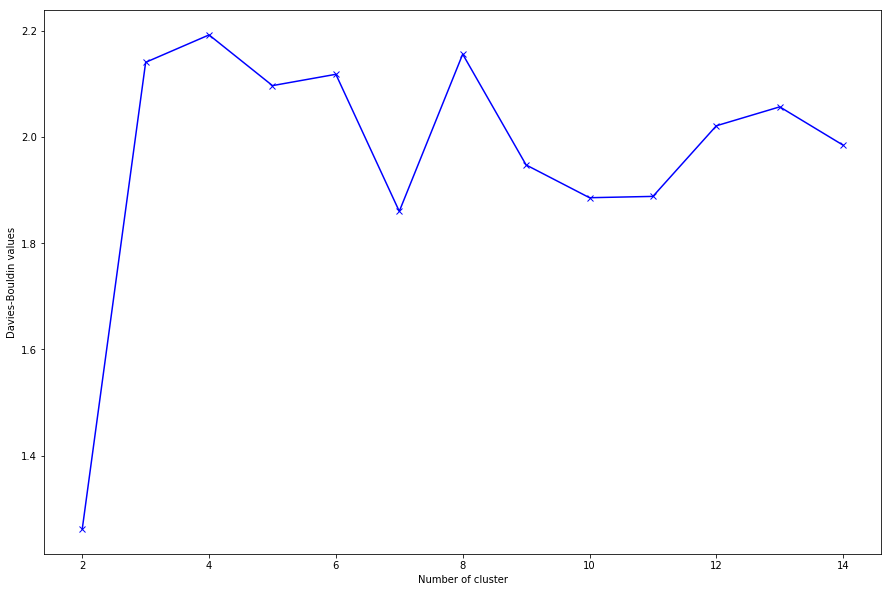

In [258]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

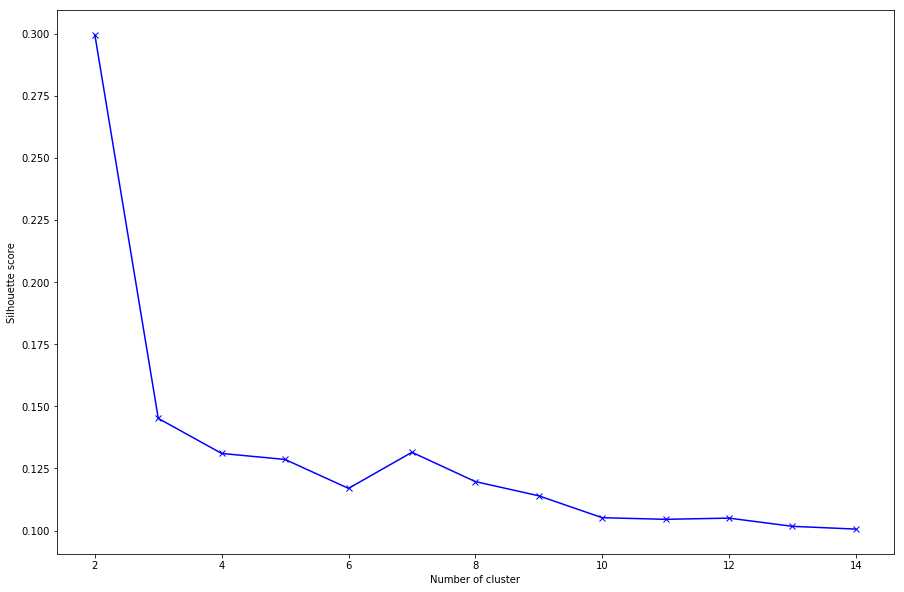

In [259]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [260]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [261]:
kmeans.fit(pca_)

KMeans(n_clusters=3, random_state=0)

In [262]:
X['cluster'] = kmeans.predict(pca_)
pca_['cluster'] = kmeans.predict(pca_)

In [263]:
pca_['cluster'] = pca_['cluster'].astype(str)

In [264]:
pca_.iplot(x="pc1", y="pc2",kind="scatter", mode='markers', categories='cluster', title=f"T-SNE 3 Componets Perplexity 60")

c:\python37\lib\site-packages\cufflinks\plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

c:\python37\lib\site-packages\cufflinks\plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [265]:
X[[x for x in X.columns if x.endswith('_id')==False]].mean()

c:\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



amount_loan                             98,143.4359
duration                                    22.6667
payments                                 4,414.1197
pay_bal                                      0.3713
balance_mean                            43,460.8900
amount_mean                              8,955.4044
balance_max                             80,690.4372
amount_max                              39,065.0299
balance_min                             15,544.1188
amount_min                                  29.2902
type_card                                    0.3590
genre                                        0.5128
age                                         40.4145
no_habitantes                          283,364.1752
no_ciudades                                  5.3120
ratio_habitantes_urbanos                    68.4363
salario_promedio                         9,571.2222
tasa_desempleo_1995                          2.9854
tasa_desempleo_1996                          3.5950
no_emprended

In [268]:
X[[x for x in X.columns if x.endswith('_id')==False]].groupby("cluster").mean().style.background_gradient(cmap='Blues')

,amount_loan,duration,payments,pay_bal,balance_mean,amount_mean,balance_max,amount_max,balance_min,amount_min,type_card,genre,age,no_habitantes,no_ciudades,ratio_habitantes_urbanos,salario_promedio,tasa_desempleo_1995,tasa_desempleo_1996,no_emprendedores_por_1000_habitantes,numero_delitos_cometidos_1995,numero_delitos_cometidos_1996,disp_count,otros,pago_arrendamiento,pago_domestico,pago_prestamo,pago_seguro,total_amount_orders,frequency
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,97579.125000,21.375000,4410.343750,0.349248,43824.212958,8899.059321,80839.731250,39746.359375,14256.606250,17.634375,0.187500,0.468750,41.656250,1204953.000000,1.000000,100.000000,12541.000000,0.290000,0.430000,167.000000,85677.000000,99107.000000,1.250000,0.375000,0.000000,0.687500,1.000000,0.250000,9826.959375,1.187500
1,110345.939394,23.515152,4806.666667,0.280626,55057.511495,12429.315476,107799.450505,51954.651515,18322.870707,25.479798,0.494949,0.444444,40.090909,133192.989899,6.080808,63.380808,9075.858586,3.587576,4.272929,112.989899,4455.717172,4478.242424,1.222222,0.313131,0.000000,0.555556,1.000000,0.111111,9637.931313,1.131313
2,86590.135922,22.252427,4037.990291,0.465212,32201.745740,5633.907735,54587.818447,26464.300971,13273.283495,36.573786,0.281553,0.592233,40.339806,141384.611650,5.912621,63.489320,9124.699029,3.243981,3.926602,115.126214,4717.582524,4734.165049,1.242718,0.456311,0.000000,0.699029,1.000000,0.242718,8591.754369,1.029126


In [272]:
X[[x for x in X.columns if x.endswith('_id')==False]].groupby("cluster").mean().to_csv("perfilamiento_prestamos.csv", index=False)

In [273]:
for i in range(0,4):
    print(i)
    display(X.loc[X.cluster==i].status.value_counts())

0


c_terminado_sin_problema          29
c_terminado_prestamo_no_pagado     3
Name: status, dtype: int64

1


c_terminado_sin_problema          87
c_terminado_prestamo_no_pagado    12
Name: status, dtype: int64

2


c_terminado_sin_problema          87
c_terminado_prestamo_no_pagado    16
Name: status, dtype: int64

3


Series([], Name: status, dtype: int64)

In [ ]:
91%-9%  -  90%-10% - 82%-18%

In [ ]:
X.loc[X.cluster==0].status.value_counts() #4-19%  3-11% -> 38% B

In [ ]:
X.loc[X.cluster==1].status.value_counts() # 4-7%  3-9% ->  9% A

In [ ]:
X.loc[X.cluster==2].status.value_counts() # 4-9%  3-16% -> 51% C

In [ ]:
X